### Author
0001128790 - Christian Di Buò - christian.dibuo@studio.unibo.it

### Importing images

In [1]:
import os, json
import subprocess, sys
import random
import math
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import MobileViTImageProcessor, MobileViTForSemanticSegmentation

In [2]:
package_name = "evaluate"

try:
    __import__(package_name)
    print('already installed')
except ImportError:
    print(f"{package_name} is NOT installed! Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name]);

evaluate is NOT installed! Installing now...


In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [4]:
import evaluate

"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
]) 

In [5]:
class StreetHazardsDataset(Dataset):
    def __init__(self, odgt_file, transform1=None, transform2=None):
        """
        Args:
            odgt_file (str): Path to the .odgt file (train, val, or test).
            transform (callable, optional): Transformations to apply to images and masks.
        """

        self.transform1 = transform1
        self.transform2 = transform2

        # Load the .odgt file
        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "annotation": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        # Build full paths for image and mask
        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        annotation = Image.open(self.paths[idx]["annotation"])

        if self.transform1:
            image = self.transform1(image)
            annotation = torch.as_tensor(transforms.functional.pil_to_tensor(annotation), dtype=torch.int64) - 1 # Make class indexes start from 0
            annotation = self.transform2(annotation).squeeze(0)

        return {'image' : image, 'labels' : annotation}


def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])



In [6]:
image_resize_scale = (512, 512)
transform1 = transforms.Compose([
    transforms.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST)
])

# Create dataset instance
train_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/train.odgt",
    transform1=transform1,
    transform2=transform2
)
val_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/validation.odgt",
    transform1=transform1,
    transform2=transform2
)
test_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_test/test/test.odgt",
    transform1=transform1,
    transform2=transform2
)

torch.Size([512, 512]) 1500


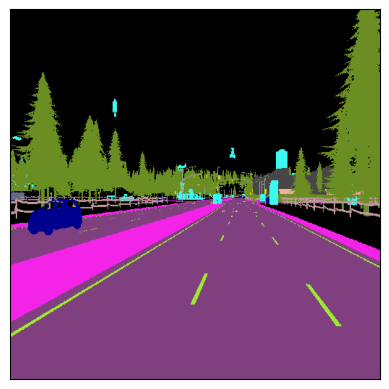

In [7]:
idx = random.randint(0, len(test_dataset))
print(test_dataset[idx]['labels'].shape, len(test_dataset))
visualize_annotation(test_dataset[idx]['labels'])

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def as_numpy(obj):
    if torch.is_tensor(obj):
        return obj.cpu().numpy()
    else:
        return np.array(obj)

In [10]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

def get_model(model_name, num_classes, weights_path = None):

    if "segformer" in model_name:
        processor = AutoImageProcessor.from_pretrained(model_name)
        model = SegformerForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    elif "deeplabv3":
        processor = MobileViTImageProcessor.from_pretrained(model_name)
        model = MobileViTForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    
    if weights_path:
        model.load_state_dict(torch.load(weights_path))
        
    model.to(DEVICE);
    
    return processor, model

In [11]:
class MeanIoU:
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/DeepLabV3Plus-Pytorch/metrics/stream_metrics.py
    """
    def __init__(self, n_classes= 13):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
        
    def update(self, label_trues, logits):
        label_preds = torch.argmax(logits, dim=1)
        label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }


In [12]:
import sklearn.metrics as sk

def get_aupr(confs, seg_labels, out_label=13):

    aupr = []
    seg_labels = as_numpy(seg_labels)
    
    for conf, seg_label in zip(confs, seg_labels):

        out_label = out_label
        in_scores = - conf[np.where(seg_label == out_label)]
        out_scores  = - conf[np.where(seg_label != out_label)]
    
        if (len(out_scores) != 0) and (len(in_scores) != 0):
            
            pos = np.array(in_scores[:]).reshape((-1, 1))
            neg = np.array(out_scores[:]).reshape((-1, 1))
            examples = np.squeeze(np.vstack((pos, neg)))
            labels = np.zeros(len(examples), dtype=np.int32)
            labels[:len(pos)] += 1
        
            aupr.append(sk.average_precision_score(labels, examples))

        aupr = np.mean(aupr)
        return aupr * 100

In [13]:
from kornia.morphology import dilation, erosion
from scipy import ndimage as ndi

d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1)).cuda()
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1)).cuda()
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1)).cuda()
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1)).cuda()
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1)).cuda()
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1)).cuda()
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1)).cuda()
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1)).cuda()
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1)).cuda()

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}


selem = torch.ones((3, 3)).cuda()
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1)).cuda()

for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)

def find_boundaries(label):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    """
    assert len(label.shape) == 4
    boundaries = (dilation(label.float(), selem_dilation) != erosion(label.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries

In [14]:
class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False)
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight)))

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False)
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel)


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)


In [15]:
class Trainer:
    def __init__(self,
                 processor,
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 device: torch.device,
                 num_classes: int,
                 cfg: dict,
                 model_name: str,
                 resume_ckpt: dict = None,
                 
        ) -> None:
        
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.patience = cfg["patience"]
        self.multi_scale = BoundarySuppressionWithSmoothing()
        self.multi_scale.to(DEVICE)
        self.processor = processor
        
        if resume_ckpt:
            self.mean_iou = cfg['mean_iou']
            self.num_epochs = cfg["num_epochs"] - resume_ckpt['epoch']
            #self.loss = 
            self.model = resume_ckpt['model_state_dict']
            self.optimizer = resume_ckpt['optimizer_state_dict']
            self.scheduler = resume_ckpt['scheduler_state_dict']

        else:
            self.mean_iou = 0.0
            self.num_epochs = cfg["num_epochs"]
            self.model = model.to(device)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
            num_steps = self.num_epochs * len(train_loader)
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0
        
        #wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    '''def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)'''

    def train(self, verbose= False) -> None:
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            
            self.model.train()

            for batch in self.train_loader:
                imgs = batch['image']
                labels = batch['labels'].to(self.device)
                imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
                pred = self.model(**imgs)
                logits = F.interpolate(pred['logits'], size=labels.shape[1:], mode='bilinear', align_corners=False)
                loss = F.cross_entropy(logits, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                '''if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})'''

            self.eval("train", epoch)
            self.eval("val", epoch)

            if self.patience < self.step:
                break
        
        #return torch.load(self.ckpt_path / "model_weights"/f"{self.model_name}.pt")

    @torch.no_grad()
    def eval(self, split: str, epoch: int) -> None:
        
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        
        mean_iou = MeanIoU()
        losses = []
        mean_avg = []
        std_avg = []
        
        for batch in loader:
            imgs = batch['image']
            labels = batch['labels'].to(self.device)
            
            imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
            pred = self.model(**imgs)

            logits = F.interpolate(pred['logits'], size=labels.shape[1:], mode='bilinear', align_corners=False)
            loss = F.cross_entropy(logits, labels)
            
            losses.append(loss.item())

            mean_iou.update(labels, logits)

        results = mean_iou.get_results()
        mean_iou = results['Mean IoU']
        loss = sum(losses) / len(losses)

        if split == "val":
            print(f"Epoch {epoch + 1} | {split.upper()} Metrics:")
            print(f"  Loss: {loss:.4f}")
            print(f"  Mean IoU: {mean_iou:.4f}\n")

        if mean_iou > self.mean_iou and split == "val":
            self.mean_iou = mean_iou
            torch.save(self.model.state_dict(), self.ckpt_path/f"{self.model_name}.pt")
            torch.save({
                'epoch': epoch,
                'mean_iou': self.mean_iou,
                #'loss': loss,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                }, self.ckpt_path / "best_checkpoint")
            
            self.best_model = copy.deepcopy(self.model)
            self.step = 0

        elif split == "val":
            self.step += 1
    
    @torch.no_grad()
    def predict(self, loader, verbose= False):

        self.model.eval()
        mean_iou = MeanIoU()
        aupr = []

        mean_logit = []
        std_logit = []
        
        for batch in tqdm(loader):
            imgs = batch['image']
            labels_true = batch['labels'].to(self.device)
            imgs = self.processor(images=imgs, return_tensors="pt", do_resize=False, do_rescale=False).to(self.device)
            pred = self.model(**imgs)
            logits = F.interpolate(pred['logits'], size=labels_true.shape[1:], mode='bilinear', align_corners=False)
            mean_iou.update(labels_true, logits)

            '''mean, std = get_mean_std(logits)
            mean_logit.append(mean)
            std_logit.append(std)
            return np.mean(mean_logit, axis = 0), np.mean(std_logit, axis = 0)'''

            """
            predictors
            """
            
            conf = maximum_softmax_probability(logits, self.multi_scale)
            #conf = max_logit(logits, self.multi_scale)
            #conf = euclidean_distance_sum(logits)
            
            '''conf = standardized_max_logit(logits, self.multi_scale,
                                          class_mean = MEAN_PER_CLASS, 
                                          class_var = VAR_PER_CLASS)'''

            conf = as_numpy(conf.squeeze(0).cpu())

            
            aupr.append(get_aupr(conf, labels_true))

        
        #pred_labels = pred_labels.cpu().numpy()
        return np.mean(aupr), mean_iou.get_results()

In [16]:
def get_mean_std(logits, num_classes = 13):

    mean_avg = np.zeros(13)
    std_avg = np.zeros(13)
    
    for logit in logits:
        conf, labels = torch.max(logit, 0)
        for c in range(num_classes):
            tens = torch.where(labels == c, conf, 0)
            mean, std = torch.std_mean(tens)

            mean_avg[c] += as_numpy(mean)
            std_avg[c] += as_numpy(std)

    return mean_avg, std_avg**2

In [17]:
def maximum_softmax_probability(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction  = torch.max(nn.functional.softmax(logits, dim=1),dim=1)

    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)
    
    return conf

In [18]:
def max_logit(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction  = torch.max(logits,dim=1)
    
    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return conf

In [19]:
def standardized_max_logit(logits, multi_scale, class_mean, class_var, num_classes = 13):


    conf, prediction  = torch.max(logits,dim=1)
    for c in range(num_classes):
        conf = torch.where(
            prediction == c,
            (conf - class_mean[c]) / np.sqrt(class_var[c]),
            conf)

    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return conf

In [20]:
def euclidean_distance_sum(logits):
    
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """

    def Normalization(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    def Coefficient_map(x, thre):
        lamda = 50
        return 1 / (1 + np.exp(lamda * (x - thre)))
        
    dis_sum = torch.sum(logits,dim=1)
    dis_sum = - as_numpy(dis_sum.squeeze(0).cpu())
    dis_sum[dis_sum >= 400] = 400
    dis_sum = Normalization(dis_sum)
    prob_map = np.max(nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy(), axis=1)
    prob_map = Normalization(prob_map)
    Coefficient = Coefficient_map(dis_sum, 0.2)
    conf = Coefficient * dis_sum + (1 - Coefficient) * prob_map
    conf = dis_sum

    return conf

### get the model

only specify the weights path if you do not want to train the model

In [21]:
#model_name = "apple/deeplabv3-mobilevit-small"
#model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024" #results 0.61 on validation and 0.5 on test mIoU
model_name = "nvidia/segformer-b1-finetuned-ade-512-512"
#weights_path = "/kaggle/input/weights/deeplab.pt"
weights_path = None

processor, model = get_model(model_name, num_classes = len(COLORS)-1, weights_path = weights_path)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([13, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"model trainable parameters are {trainable_params/1000000} milions")

model trainable parameters are 13.680589 milions


In [23]:
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

### model training

In [24]:
cfg = {
    "num_epochs" : 100,
    "lr": 2e-4,
    "wd": 0.001,
    "patience": 10,
}

In [25]:
trainer = Trainer(
    processor = processor,
    model= model,
    train_loader= train_dl,
    val_loader= val_dl ,
    device= DEVICE,
    num_classes = len(COLORS)-1,
    model_name = 'deeplab',
    cfg= cfg
)

In [26]:
MEAN_PER_CLASS = [1.72267947e+01, 7.66881425e+00, 5.77455433e-01, 4.47677614e-02,
 0.00000000e+00, 3.41044600e-01, 1.39990459e+00, 2.11263614e+01,
 7.31018189e+00, 7.46783295e+00, 1.15309967e-02, 2.41669891e+00,
 0.00000000e+00]
VAR_PER_CLASS = [1.33243940e+02, 1.53900278e+01, 2.14974713e-02, 3.87089461e-05,
 0.00000000e+00, 7.03953145e-03, 8.06856298e-02, 2.19127594e+02,
 5.62604913e+00, 8.48272837e+00, 1.52454267e-05, 8.70028476e-01,
 0.00000000e+00]

In [27]:
trainer.train()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 | VAL Metrics:
  Loss: 0.6837
  Mean IoU: 0.3012



Epoch:   1%|          | 1/100 [17:00<28:03:45, 1020.46s/it]

Epoch 2 | VAL Metrics:
  Loss: 0.4902
  Mean IoU: 0.3317



Epoch:   2%|▏         | 2/100 [33:37<27:23:51, 1006.44s/it]

Epoch 3 | VAL Metrics:
  Loss: 0.4167
  Mean IoU: 0.3558



Epoch:   3%|▎         | 3/100 [50:04<26:53:04, 997.78s/it] 

Epoch 4 | VAL Metrics:
  Loss: 0.3675
  Mean IoU: 0.4094



Epoch:   4%|▍         | 4/100 [1:06:30<26:29:03, 993.16s/it]

Epoch 5 | VAL Metrics:
  Loss: 0.3353
  Mean IoU: 0.4829



Epoch:   5%|▌         | 5/100 [1:22:56<26:08:22, 990.55s/it]

Epoch 6 | VAL Metrics:
  Loss: 0.3402
  Mean IoU: 0.5091



Epoch:   6%|▌         | 6/100 [1:39:24<25:50:13, 989.51s/it]

Epoch 7 | VAL Metrics:
  Loss: 0.3234
  Mean IoU: 0.5235



Epoch:   8%|▊         | 8/100 [2:12:20<25:16:22, 988.94s/it]

Epoch 8 | VAL Metrics:
  Loss: 0.4011
  Mean IoU: 0.5161

Epoch 9 | VAL Metrics:
  Loss: 0.3489
  Mean IoU: 0.5353



Epoch:   9%|▉         | 9/100 [2:28:46<24:58:29, 988.02s/it]

Epoch 10 | VAL Metrics:
  Loss: 0.3535
  Mean IoU: 0.5660



Epoch:  10%|█         | 10/100 [2:45:14<24:42:05, 988.06s/it]

Epoch 11 | VAL Metrics:
  Loss: 0.3827
  Mean IoU: 0.5699



Epoch:  11%|█         | 11/100 [3:01:43<24:25:54, 988.26s/it]

Epoch 12 | VAL Metrics:
  Loss: 0.3982
  Mean IoU: 0.5749



Epoch:  12%|█▏        | 12/100 [3:18:10<24:08:55, 987.90s/it]

Epoch 13 | VAL Metrics:
  Loss: 0.4028
  Mean IoU: 0.5929



Epoch:  13%|█▎        | 13/100 [3:34:37<23:52:12, 987.73s/it]

Epoch 14 | VAL Metrics:
  Loss: 0.3846
  Mean IoU: 0.6001



Epoch:  14%|█▍        | 14/100 [3:51:06<23:36:13, 988.06s/it]

Epoch 15 | VAL Metrics:
  Loss: 0.3566
  Mean IoU: 0.6093



Epoch:  15%|█▌        | 15/100 [4:07:34<23:19:27, 987.85s/it]

Epoch 16 | VAL Metrics:
  Loss: 0.4042
  Mean IoU: 0.6118



Epoch:  17%|█▋        | 17/100 [4:40:30<22:46:28, 987.81s/it]

Epoch 17 | VAL Metrics:
  Loss: 0.4149
  Mean IoU: 0.5900



Epoch:  18%|█▊        | 18/100 [4:56:56<22:29:16, 987.28s/it]

Epoch 18 | VAL Metrics:
  Loss: 0.4168
  Mean IoU: 0.6096



Epoch:  19%|█▉        | 19/100 [5:13:23<22:12:50, 987.29s/it]

Epoch 19 | VAL Metrics:
  Loss: 0.3939
  Mean IoU: 0.5620



Epoch:  20%|██        | 20/100 [5:29:48<21:55:29, 986.62s/it]

Epoch 20 | VAL Metrics:
  Loss: 0.4409
  Mean IoU: 0.6026



Epoch:  21%|██        | 21/100 [5:46:10<21:37:16, 985.27s/it]

Epoch 21 | VAL Metrics:
  Loss: 0.4609
  Mean IoU: 0.5826



Epoch:  22%|██▏       | 22/100 [6:02:32<21:19:26, 984.19s/it]

Epoch 22 | VAL Metrics:
  Loss: 0.4680
  Mean IoU: 0.5878



Epoch:  23%|██▎       | 23/100 [6:18:57<21:03:13, 984.33s/it]

Epoch 23 | VAL Metrics:
  Loss: 0.4572
  Mean IoU: 0.6032



Epoch:  24%|██▍       | 24/100 [6:35:18<20:45:39, 983.42s/it]

Epoch 24 | VAL Metrics:
  Loss: 0.4223
  Mean IoU: 0.5736



Epoch:  25%|██▌       | 25/100 [6:51:41<20:29:11, 983.36s/it]

Epoch 25 | VAL Metrics:
  Loss: 0.4526
  Mean IoU: 0.5946



Epoch:  26%|██▌       | 26/100 [7:08:04<20:12:36, 983.20s/it]

Epoch 26 | VAL Metrics:
  Loss: 0.4482
  Mean IoU: 0.5891



Epoch:  26%|██▌       | 26/100 [7:24:26<21:04:56, 1025.63s/it]

Epoch 27 | VAL Metrics:
  Loss: 0.4916
  Mean IoU: 0.5860



In [28]:
result = trainer.predict(val_dl)
#print(result[0])
print(result[1])

  0%|          | 0/258 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 258/258 [00:34<00:00,  7.37it/s]

{'Overall Acc': 0.9117662002459876, 'Mean Acc': 0.6923789418251505, 'FreqW Acc': 0.8440143864711562, 'Mean IoU': 0.585959282738414, 'Class IoU': {0: 0.86471233413735, 1: 0.8010063391346167, 2: 0.4421991423622361, 3: 0.3252976370068903, 4: 0.33682294037323623, 5: 0.3014092553188075, 6: 0.7065941279213024, 7: 0.9358455827619031, 8: 0.767915578062485, 9: 0.86230586514311, 10: 0.5475682268638512, 11: 0.3625523987821244, 12: 0.3632412477314678}}


In [29]:
result = trainer.predict(test_dl)
print(result[1])

100%|██████████| 375/375 [01:09<00:00,  5.36it/s]

{'Overall Acc': 0.9133742056311497, 'Mean Acc': 0.6889776497932791, 'FreqW Acc': 0.8511352499483432, 'Mean IoU': 0.546191062634983, 'Class IoU': {0: 0.8703701016157821, 1: 0.7340963366649716, 2: 0.3433381972441182, 3: 0.26613493087412887, 4: 0.0, 5: 0.3250464103065903, 6: 0.5933813917079344, 7: 0.9603581075463776, 8: 0.7318804542474924, 9: 0.837622272488885, 10: 0.6533165856835853, 11: 0.42823377294991727, 12: 0.35670525292499466}}



<ipython-input-11-689c142c12df>:32: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)


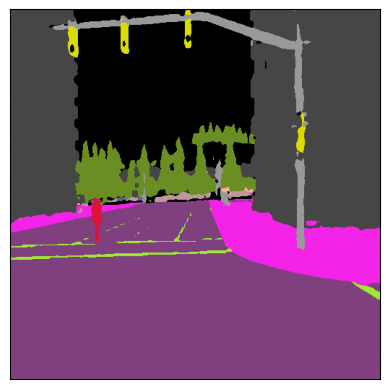

In [30]:
@torch.no_grad()
def get_predictions(img):
    img = img.unsqueeze(0)
    img = processor(images=img, return_tensors="pt", do_resize=False, do_rescale=False).to(DEVICE)
    pred = model(**img)
    log = F.interpolate(pred['logits'], size=(512, 512), mode='bilinear', align_corners=False)
    log = log.cpu()
    log = torch.argmax(log, dim=1)
    log = log.squeeze(0)
    return log

tst_idx = 1000
dataset = val_dataset
img = dataset[tst_idx]['image']
visualize_annotation(get_predictions(img))

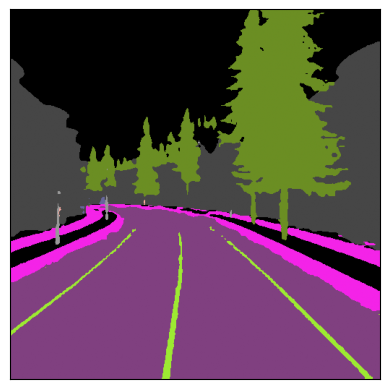

In [31]:
tst_idx = 500
dataset = val_dataset
img = dataset[tst_idx]['image']
visualize_annotation(get_predictions(img))

### AUPR Results:
- standardized max logit is the worst performer: 6.11 (if use boundiary suppression it goes up to 7.sth)
- max logit: 7.65
- maximum softmax probability: 11.33
- euclidean distance: 15.31

### TODO: should i compute mean iou after the computation of the anomaly scores (in this way mean iou changes after softmax etc).
### TODO: implement class AUPR